# Outlier Detection

This notebook will walk you through a workflow for outlier detection.

## TOC

 * [Detecting outlier jobs](#detect-outlier-jobs-study-1)
  * [Getting comparable jobs](#comparable-jobs)
  * [outlier detection using other features](#using-other-features)
  * [wildcard features](#wildcard-features)
  * [Multivariate Outlier Detection](#multivariate-eod)
    * [Trained Models](#trained-models)
  * [EPMT Explore API](#epmt-exp-explore)
  * [EPMT Explore CLI](#epmt-explore-cli)
  * [Principal Component Analysis (PCA) and Dimensionality Reduction](#pca)
    * [PCA Feature Ranking](#pca-feature-rank)
    * [PCA Feature Plots](#pca-feature-plots)
    * [PCA-based Trained Models](#trained-models-pca)
 * [Root Cause Analysis (RCA)](#rca-job)
 * [Detecting outlier operations](#detect-outlier-ops)
  * [RCA for operations](#rca-ops)

## <a name="detect-outlier-jobs-study-1">Detecting outlier jobs</a>

In this example we will study a variety of approaches to indentify outlier
jobs from among set of jobs within an *experiment*.

We will start with using univariate classifiers, and then work our way to 
multivariate classification techniques. Finally, we will look at PCA (principal
component analysis) as means to reduce data dimensionality and to aid both
in data visualization and root cause analysis (RCA). For our studies we will use
the *epmt outlier detection* and the *epmt query* API. 

We will use data from the `ESM4_hist-piAer_D1` experiment.


### Requirements

You will need to import data:
```
# use the SQLAlchemy ORM and a SQLite backend. You may instead choose
# to use the postgresql backend (settings_pg_localhost_sqlalchemy.py)
$ cp preset_settings/settings_sqlite_localfile_sqlalchemy.py settings.py

# Backup earlier database if it exists
$ mv ~/EPMT_DB.sqlite ~/EPMT_DB.sqlite.backup

# now import the needed job files into the DB
# We load jobs from 4 time segments: 1854, 1859, 1864, 1869
# As the entire ESM4_hist-piAer_D1 experiment has a lot of data
# -- more than needed here --
# and we also want comparable jobs for outlier detection we will also
# selectively load jobs for a single component -- atmos_cmip.
# This is the most important (longest by duration) in the experiment
# The jobs will take about 20-25 minutes to load.
$ epmt submit test/data/outliers_nb/*.tgz

```

In [15]:
# epmt_query contains the EPMT Query API
import epmt_query as eq
# epmt_outliers contains the EPMT Outlier Detection API
import epmt_outliers as eod
# epmt_stat contains statistical functions
import epmt_stat as es
import pandas as pd
import numpy as np

In [2]:
jobs = eq.get_jobs(tags='exp_name:ESM4_hist-piAer_D1', fmt='terse')
len(jobs)

127

### <a name="comparable-jobs">Getting Comparable Jobs</a>
Not all these jobs are comparable to each other (since they have
different components. We need to partition the jobs into sets that are of
the same component.

The function below returns a list sorted in decreasing order of cumulative duration
for the jobs of the component. This way we know that first tuple represents the
component of the longest duration.

In [3]:
comp_job_parts = eq.comparable_job_partitions(jobs)
comp_job_parts

[(('ESM4_hist-piAer_D1', 'atmos_cmip'),
  ['2444931',
   '2460340',
   '2494089',
   '2501763',
   '2546910',
   '2549352',
   '2557075',
   '2568088',
   '2577413',
   '2579660',
   '2581160',
   '2587725',
   '2600696',
   '2605559',
   '2621360',
   '2626358',
   '2628013',
   '2632680',
   '2641421']),
 (('ESM4_hist-piAer_D1', 'aerosol_cmip'),
  ['2444929', '2460338', '2494087', '2501761']),
 (('ESM4_hist-piAer_D1', 'tracer_level'),
  ['2444963', '2460367', '2494114', '2501788']),
 (('ESM4_hist-piAer_D1', 'land_cmip'),
  ['2444941', '2460345', '2494093', '2501767']),
 (('ESM4_hist-piAer_D1', 'atmos'),
  ['2444930', '2460339', '2494088', '2501762']),
 (('ESM4_hist-piAer_D1', 'atmos_level'),
  ['2444933', '2460342', '2494091', '2501765']),
 (('ESM4_hist-piAer_D1', 'land_dust'),
  ['2444942', '2460346', '2494094', '2501768']),
 (('ESM4_hist-piAer_D1', 'river'),
  ['2444962', '2460366', '2494113', '2501787']),
 (('ESM4_hist-piAer_D1', 'ocean_inert_month_1x1deg'),
  ['2444957', '2460361

You may notice that for `atmos_cmip` we have a number of jobs, while for
the other components we have only 4 jobs each. That's because we loaded
all the `atmos_cmip` jobs in the database, but only the first four time
segments for the other components. 

While we have some powerful functions and commands to speed up
the process let's do some manual digging first so we have a better
feel of the process. Let's focus on the first component: `atmos_cmip`.
Let's see if the jobs of `atmos_cmip` have any outliers.

In [4]:
# As a first pass let's see whether the outliers can be auto-detected
atmos_cmip_jobs = eq.get_jobs(tags='exp_name:ESM4_hist-piAer_D1;exp_component:atmos_cmip', fmt='terse')
(df, _) = eod.detect_outlier_jobs(atmos_cmip_jobs)
df

,jobid,cpu_time,duration,num_procs
0,2444931,0,0,3
1,2460340,0,3,1
2,2494089,0,0,0
3,2501763,0,0,0
4,2546910,0,0,1
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0
9,2579660,1,0,1


In the dataframe above the number of outlier detection methods that considered the job to be an outlier based on a particular feature. So the higher the score, the greater the probability of the job being an outlier. 

Let's sort the dataframe by the sum of the scores across the features.

In [8]:
df['score'] = 0
df['score'] = df.sum(axis=1)
sorted_df = df.sort_values('score', ascending=False)
sorted_df[['jobid', 'cpu_time', 'duration', 'num_procs']]

,jobid,cpu_time,duration,num_procs
1,2460340,0,3,1
0,2444931,0,0,3
13,2605559,3,0,0
9,2579660,1,0,1
4,2546910,0,0,1
11,2587725,0,0,1
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0


Based on the scoring it seems `2460340`, `244931` and `2605559` might be outliers.

We use three methods -- IQR (interquartile range), MADZ (modified adjusted z-score) and Z-score -- as the default methods for univariate outlier detection. These are specified, along with their thresholds, in `settings.py`. You can choose different defaults by changing `univariate_classifiers` in `settings.py`. You may also use the `methods` argument to specify different outlier detection methods when calling `detect_outlier_jobs`.

### <a name="using-other-features">Outlier detection using other metrics</a>
By default, `detect_outlier_jobs` uses `num_procs`, `duration` and `cpu_time`
as the **features** for outlier detection. Often times we care most about `duration`
(wallclock time). At other times we care about the actual CPU cycles, represented by
`cpu_time`. `num_procs` represents the number of processes in the job, and can often
help in outlier detection in case of process retries. So, you will normally be
satisfied with our default feature choices. However, if one desires one can pass the
`features` argument to the call to select some other features. You can also pass the wildcard
`'*'` to select all available features.

In [9]:
# Let's get the list of availabe features
eq.get_features(atmos_cmip_jobs)

['PERF_COUNT_SW_CPU_CLOCK',
 'cancelled_write_bytes',
 'cmajflt',
 'cminflt',
 'cpu_time',
 'cstime',
 'cutime',
 'delayacct_blkio_time',
 'duration',
 'exitcode',
 'guest_time',
 'inblock',
 'invol_ctxsw',
 'majflt',
 'minflt',
 'num_procs',
 'num_threads',
 'outblock',
 'processor',
 'rchar',
 'rdtsc_duration',
 'read_bytes',
 'rssmax',
 'submit',
 'syscr',
 'syscw',
 'systemtime',
 'time_oncpu',
 'time_waiting',
 'timeslices',
 'updated_at',
 'usertime',
 'vol_ctxsw',
 'wchar',
 'write_bytes']

For a description of these events you can refer to `docs/metrics.md` in the EPMT install.

It's tedious to type out all the features, so we support <a name="wildcard-features">wildcard features</a>
as shown in the following examples.

In [10]:
(df, _) = eod.detect_outlier_jobs(atmos_cmip_jobs, features='*')
df

,jobid,PERF_COUNT_SW_CPU_CLOCK,cancelled_write_bytes,cmajflt,cminflt,cpu_time,cstime,cutime,delayacct_blkio_time,duration,...,syscr,syscw,systemtime,time_oncpu,time_waiting,timeslices,usertime,vol_ctxsw,wchar,write_bytes
0,2444931,0,2,0,3,0,0,0,0,0,...,3,3,0,0,0,3,0,3,3,3
1,2460340,0,0,0,0,0,0,1,0,3,...,1,2,0,0,1,0,0,0,0,0
2,2494089,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2501763,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2546910,0,0,2,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
5,2549352,0,0,0,0,0,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0
6,2557075,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2568088,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,2577413,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
9,2579660,1,0,0,0,1,0,1,0,0,...,0,0,1,1,1,0,1,0,0,0


In [11]:
# As there are a lot of features let us get a composite score for each jobid across all features
df['score'] = 0
df['score'] = df.sum(axis=1)
df[['jobid', 'score']].sort_values('score', ascending=False)

,jobid,score
0,2444931,46
13,2605559,37
1,2460340,14
4,2546910,13
9,2579660,13
16,2628013,10
17,2632680,7
11,2587725,6
14,2621360,6
5,2549352,5


Judging by these outlier scores it seems `2605559` and `2444931` are prime candidates to be outliers, while `2460340` might be slightly less so. 

You might be wondering why using multiple features increased the likelihood of `2605559` and `2444931` in contrast to `2460340`. One intuition for that is that jobs that are considered by to be outliers by features such as `num_procs` or `cpu_time`, will end up getting a boost in scores as a number of features are strontly correlated to these features. In contrast, jobs that are classified as outliers on the basis of `duration` will not get that boost, since only `rdtsc_duration` is strongly correlated to `duration`. Most of the other features are not. This will also become apparent when we consider *feature ranking using PCA* in a later section.

## <a name="multivariate-eod">Multivariate Outlier Detection</a>

We will now look at outlier detection using multivariate classifiers. Multivariate
classifiers look at multiple features *simultaneously* while doing outlier detection.
They may often perform better than univariate classifiers.

### <a name="trained-models">Trained (reference) models</a>

Multivariate classifiers require a *trained model*. For that we need to get a
version of truth. In other words, which jobs are representative. 

First let's run univariate classifiers to determine which jobs are inliers. We
will use a subset of the inliers to create a trained model.

In [12]:
df, _ = eod.detect_outlier_jobs(atmos_cmip_jobs)
df

,jobid,cpu_time,duration,num_procs
0,2444931,0,0,3
1,2460340,0,3,1
2,2494089,0,0,0
3,2501763,0,0,0
4,2546910,0,0,1
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0
9,2579660,1,0,1


Now let's select those jobs that are not showing outliers for any features.

In [23]:
df['score'] = 0
df['score'] = df.sum(axis=1)
inliers_df = df[df.score == 0][['jobid', 'cpu_time', 'duration', 'num_procs']]
inliers_df

,jobid,cpu_time,duration,num_procs
2,2494089,0,0,0
3,2501763,0,0,0
5,2549352,0,0,0
6,2557075,0,0,0
7,2568088,0,0,0
8,2577413,0,0,0
10,2581160,0,0,0
12,2600696,0,0,0
14,2621360,0,0,0
15,2626358,0,0,0


Let's select a random subset of 4 jobs from among these to create a trained model. 

Here we use the default features `['cpu_time', 'duration', 'num_procs']` while creating the trained model. We could instead specify `features`. As before, we can use the wildcard (`'*'`) to specify all available features.

In [52]:
rand = np.random.RandomState(42)
num_inliers = len(inliers_df)
selected_indices = np.sort(rand.choice(num_inliers, 4, replace=False))
selected_indices

array([ 0,  8,  9, 11])

In [53]:
model_jobs = list(inliers_df.jobid.iloc[selected_indices].values)
model_jobs

['2494089', '2621360', '2626358', '2632680']

In [54]:
r = eq.create_refmodel(model_jobs, outlier_methods=es.mvod_classifiers())
r

{'jobs': ['2494089', '2621360', '2626358', '2632680'],
 'name': None,
 'tags': {},
 'op_tags': [],
 'computed': {'pyod.models.mcd': {'cpu_time,duration,num_procs': [2.8031,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0, 36262018973.0, 104779.0],
     [13561761036.0, 21122417938.0, 104779.0],
     [15447854905.0, 23934831859.0, 104779.0]]]},
  'pyod.models.cof': {'cpu_time,duration,num_procs': [1.1836,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0, 36262018973.0, 104779.0],
     [13561761036.0, 21122417938.0, 104779.0],
     [15447854905.0, 23934831859.0, 104779.0]]]},
  'pyod.models.hbos': {'cpu_time,duration,num_procs': [6.2109,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0, 36262018973.0, 104779.0],
     [13561761036.0, 21122417938.0, 104779.0],
     [15447854905.0, 23934831859.0, 104779.0]]]},
  'pyod.models.pca': {'cpu_time,duration,num_procs': [43.0159,
    [[16052970720.0, 29236399996.0, 104781.0],
     [15412867040.0

The trained model is saved in the database. 

We use number of multivariate classifiers from [PYOD](https://pyod.readthedocs.io/en/latest/). 
If you are unfamiliar with outlier detection using PYOD, you might want to read [this tutorial](https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9).

Now let us use this model to do outlier detection over all the jobs from this component.

In [55]:
df, model_scores = eod.detect_outlier_jobs(atmos_cmip_jobs, methods=es.mvod_classifiers(), trained_model=r['id'])
df.sort_values('outlier', ascending=False)

,jobid,outlier
1,2460340,4
0,2444931,2
16,2628013,2
9,2579660,2
4,2546910,1
5,2549352,1
3,2501763,1
11,2587725,1
13,2605559,1
6,2557075,0


Multivariate outlier detection seems to suggest `2460340` is most likely to be an outlier, while
`244931` to a lesser extent, and `2605559` even less. One reason that this differs from
multimode univariate detection with wildcard features is that, with wildcard features we give `duration` a far lower weightage than features strongly correlated with `cpu_time` and `num_procs`. This tends to make
`2460340` be labelled more as an outlier.

Another aspect governing the outlier detection is our selection of `model_jobs`.

### <a name="epmt-exp-explore">EPMT Explore API</a> 

You might be feeling manually figuring outliers one component at a time
is tedious and slow. We have some more powerful API calls that can help.

The EPMT Explore API makes it easy to compare jobs within an experiment across different
time-segments (sharing the same component).

In [9]:
# we need to import a separate library for exploring into experiments
import epmt_exp_explore as exp_explore

In [10]:
# this call gives a list sorted by the top components ordered by decreasing order
# of a metric summed across all the jobs of a metric. Here we choose the metric
# to be 'duration' and limit to the top-5 components.
# The best part is that the call already gives outliers scores. A score
# greater than 0 means the corresponding job is an outlier. The higher the score
# the higher the chance the job is an outlier. 
exp_explore.exp_component_outliers('ESM4_hist-piAer_D1', metric = 'duration', limit=5) 

[{'exp_component': 'atmos_cmip',
  'exp_times': ['18540101',
   '18590101',
   '18640101',
   '18690101',
   '18740101',
   '18790101',
   '18840101',
   '18890101',
   '18940101',
   '18990101',
   '19040101',
   '19090101',
   '19140101',
   '19190101',
   '19240101',
   '19290101',
   '19340101',
   '19390101',
   '19440101'],
  'jobids': ['2444931',
   '2460340',
   '2494089',
   '2501763',
   '2546910',
   '2549352',
   '2557075',
   '2568088',
   '2577413',
   '2579660',
   '2581160',
   '2587725',
   '2600696',
   '2605559',
   '2621360',
   '2626358',
   '2628013',
   '2632680',
   '2641421'],
  'metrics': array([3.28558294e+10, 2.04199143e+11, 2.92364000e+10, 2.36867758e+10,
         2.35996094e+10, 2.83514334e+10, 3.70291354e+10, 3.22422714e+10,
         2.22757602e+10, 2.24129515e+10, 2.77248308e+10, 3.44615325e+10,
         2.37043384e+10, 1.83414715e+10, 3.62620190e+10, 2.11224179e+10,
         4.40920051e+10, 2.39348319e+10, 3.87362813e+10]),
  'outlier_scores': array([0.

There is a lot of data above, so let's go through it carefully. For each component
(again ordered by the longest first), we have `exp_times`, `jobids`, `metrics` and
`outlier_scores`. The arrays have the same length and are correspondingly ordered.

Most interesting in this data is that it's always the second job in each component
that's an outlier. This corresponds to the time-segment `18590101` being an outlier
time-segment as a whole! 

### <a name="epmt-explore-cli">EPMT Explore CLI</a>
Another tool we have in our arsenal as we deep-dive into experiments is the
command `epmt explore`. As it is a shell command, remember to prefix it with
a '!' in the notebook.

In [11]:
!epmt explore ESM4_hist-piAer_D1


top 10 components by sum(duration):
       component           sum                  min          max   cv
      atmos_cmip: 724269037393 [27.9%]  18341471496 204199142602  1.0
    aerosol_cmip: 231354197391 [ 8.9%]  10153792721 190797258254  1.3
    tracer_level: 221748381029 [ 8.5%]   7790096988 186490389153  1.4
       land_cmip: 221357047122 [ 8.5%]   6767103209 188810565604  1.4
           atmos: 213604322234 [ 8.2%]   5939740040 184454576055  1.4
     atmos_level: 213582094835 [ 8.2%]   5792509494 185460453836  1.4
       land_dust: 212434109350 [ 8.2%]   5072225424 185102124432  1.4
           river: 208332928054 [ 8.0%]   5324197745 185639226822  1.5
ocean_inert_mont: 186783450315 [ 7.2%]   5657762994 161584773372  1.4
ocean_cobalt_flu: 164048147551 [ 6.3%]   4765560367 140959995935  1.4

variations across time segments (by component):
       component     exp_time        jobid         duration
      atmos_cmip     18540101      2444931      32855829382       
      atmos_cmip 

The output is self-explanatory. The outliers are marked with asterisks,
the more the asterisks the greater the outlier. We use multimode score
using a number of univariate classifiers. 

You will notice that the first four time-segments take a bulk of the time.
That's an artifact of the fact that we loaded all the jobs of the first
four time-segments, but only one job each from the remaining segments. So for
now you can safely ignore the variation across time-segments.

In the example above we use the default metric -- `duration`. It shows quite clearly
that the time-segment `18590101` is affected and took far longer.
The output with `cpu_time` metric is also instructive. Have a look:

In [12]:
!epmt explore --metric cpu_time ESM4_hist-piAer_D1


top 10 components by sum(cpu_time):
       component           sum                  min          max   cv
      atmos_cmip: 281553223296 [78.2%]   8919433292  16487905141  0.1
    aerosol_cmip:  18618881029 [ 5.2%]   3969568491   4905402152  0.1
    tracer_level:  13582002508 [ 3.8%]   2570281911   4111950015  0.2
       land_cmip:   8118790419 [ 2.3%]   1742520351   2425312535  0.1
           atmos:   8063244053 [ 2.2%]   1089856333   3661044281  0.5
ocean_inert_mont:   7917665546 [ 2.2%]   1647569929   2492882916  0.2
     atmos_level:   7157903022 [ 2.0%]   1306630387   2944876599  0.4
ocean_monthly_z_:   6899290003 [ 1.9%]   1491928295   2025721148  0.1
ocean_inert_z_1x:   4023442544 [ 1.1%]    781808967   1423019293  0.2
ocean_cobalt_sfc:   3923077492 [ 1.1%]    752897613   1467064093  0.3

variations across time segments (by component):
       component     exp_time        jobid         cpu_time
      atmos_cmip     18540101      2444931      14993597755       
      atmos_cmip 

The `cpu_time` data suggests that the `18590101` took *less* cpu cycles. Yet it
took longer to finish. One hypothesis that could explain the seeming contradiction
is if the node(s) where the `18590101` were time-sharing with other concurrently
running jobs.

### <a name="pca">Principal Component Analysis and Dimensionality Reduction</a>

The job model contains a lot of metrics (or features). You may wonder which subset
of features to use for outlier detection. Fortunately, this is a well-studied 
subject in mathematics. Principal component analysis attempts to derive new
orthogonal sythetic features that capture much of the variance in the original
data, where we tradeoff many dimensions for comparitively little loss in data
variance.

Let's work through an example. Here we pick jobs that share the same component, so they
are comparable.

In [13]:
jobs = eq.get_jobs(tags='exp_name:ESM4_historical_D151;exp_component:ocean_annual_z_1x1deg', fmt='terse')
jobs

['625151',
 '627907',
 '629322',
 '633114',
 '675992',
 '680163',
 '685001',
 '691209',
 '693129']

In [14]:
# for PCA we should *always* pass in all available features ([] or '*' accomplish that)
df, _ = eod.detect_outlier_jobs(jobs, features=[], pca=2)
df

,jobid,pca_weighted,pca_01,pca_02
0,625151,4.2,1,0
1,627907,1.0,0,1
2,629322,1.0,0,1
3,633114,0.0,0,0
4,675992,0.0,0,0
5,680163,0.0,0,0
6,685001,0.0,0,0
7,691209,0.0,0,0
8,693129,0.0,0,0


When using PCA we must remember all resultant PCA columns are not of equal weight.
`pca_01` has significant higher weightage than `pca_02`. To make it easier for the
end user, we create a column with the weighted score -- `pca_weighted`. We can see
that job `625151` is an outlier by this measure.

#### <a name="pca-feature-rank">PCA Feature Ranking</a>
PCA can do more than dimensionality reduction. It can also determine which of the
original features accounted for the variance in the job data and to what degree.
It's a form of *feature ranking*. Let's see it in action.

In [15]:
df, sorted_features = eod.pca_feature_rank(jobs)
df

,rssmax,syscr,num_procs,num_threads,rchar,syscw,wchar,minflt,timeslices,vol_ctxsw,...,inblock,read_bytes,cancelled_write_bytes,majflt,rdtsc_duration,invol_ctxsw,exitcode,delayacct_blkio_time,guest_time,processor
0,0.2357,0.2356,0.2358,0.2358,0.2359,0.2359,0.2359,0.2367,0.2364,0.2366,...,0.0474,0.0474,0.0255,-0.0082,0.0609,0.0348,0.0,-0.0,0.0,-0.0
1,-0.0618,-0.0622,-0.0596,-0.0596,-0.0595,-0.0593,-0.0590,-0.0503,-0.0493,-0.0476,...,0.4724,0.4724,-0.4447,0.4652,0.1505,-0.0732,0.0,-0.0,0.0,-0.0
2,0.2023,0.2022,0.2019,0.2019,0.2019,0.2019,0.2019,0.2008,0.2004,0.2002,...,0.1292,0.1292,0.1061,0.0961,0.0782,0.0422,0.0,0.0,0.0,0.0


The dataframe consists of three rows. The first two contain the coefficients of the features
that were used to obtain the PCA components. The first row corresponds to `pca_01`, while the
second to `pca_02`. As before, the first row is significantly more important that the second.
The third row is a weighted combination of the first two rows by applying the same weights
as the PCA variance rations of `pca_01` and `pca_02`. In short, the user can just focus on 
the third row. And, indeed `sorted_features` the second item in the return tuple is just 
the features ranked with their scores:

In [16]:
sorted_features

[('rssmax', 0.2023),
 ('syscr', 0.2022),
 ('num_procs', 0.2019),
 ('num_threads', 0.2019),
 ('rchar', 0.2019),
 ('syscw', 0.2019),
 ('wchar', 0.2019),
 ('minflt', 0.2008),
 ('timeslices', 0.2004),
 ('vol_ctxsw', 0.2002),
 ('PERF_COUNT_SW_CPU_CLOCK', 0.2),
 ('cpu_time', 0.199),
 ('time_oncpu', 0.1989),
 ('usertime', 0.1944),
 ('time_waiting', 0.1928),
 ('write_bytes', 0.1912),
 ('outblock', 0.1912),
 ('systemtime', 0.1799),
 ('duration', 0.1344),
 ('inblock', 0.1292),
 ('read_bytes', 0.1292),
 ('cancelled_write_bytes', 0.1061),
 ('majflt', 0.0961),
 ('rdtsc_duration', 0.0782),
 ('invol_ctxsw', 0.0422),
 ('exitcode', 0.0),
 ('delayacct_blkio_time', 0.0),
 ('guest_time', 0.0),
 ('processor', 0.0)]

What does it mean? Well, according to the PCA analysis it appears that `rssmax`, `num_procs` was
a greater predictor on the overall characteristics of the job than say, `processor`, which had
no bearing at all. It seems to suggest the variances *among* the jobs was best captured by something
that was a proxy for `num_procs` rather than say `rdtsc_duration`.

#### <a name="pca-feature-plots">PCA Feature Plots</a>

Often it's helpful to visualize scatter plots against important features. PCA provides a
powerful medium to do so as they allow us to reduce the dimensions to something fewer, like 2,
so we can easily plot it.

Lets see an example. Here we pass the `jobs` from the previous example. The `feature_plot_2d` can
take an argument `feature`, which we could set to something like `['cpu_time', 'duration']`. However,
we choose the default which is to use all available features, and do a PCA analysis prior to 
plotting. The results clearly show `625151` is an outlier. The graph is deliberately scaled according
to the relative variances of the PCA components, so we get a fairer picture (an outlier along
the `pca_02` axis has lesser weightage than an outlier along the `pca_01` axis. By automatically
scaling the plot, we capture that aspect.

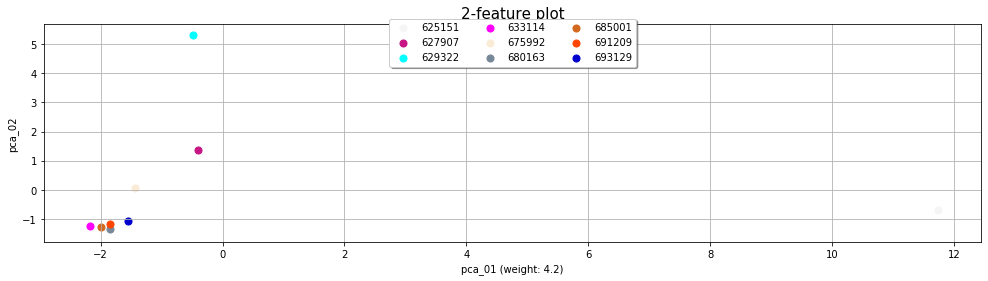

In [17]:
%matplotlib inline
eod.feature_plot_2d(jobs)

## <a name="multivariate-eod">Multivariate Outlier Detection</a>

We will now look at outlier detection using multivariate classifiers. 

#### <a name="trained-models-pca">PCA-based Trained Models</a>

In the example above we used only the default features. Since we don't know what
features are important PCA can again come to the rescue. Our trained models support
automatic PCA. Let's try the same example using multimodel univariate classifiers with
PCA enabled. 

Notice, we set `pca=2` when creating the model to use automatic 2-component
PCA. We deliberately use features other than `duration` and `rdtsc_duration`.

In [22]:
jobs = eq.get_jobs(tags='exp_name:ESM4_hist-piAer_D1;exp_component:atmos_cmip', fmt='terse') 

In [23]:
FEATURES=['PERF_COUNT_SW_CPU_CLOCK', 'cancelled_write_bytes', 'cmajflt', 'cminflt', 'cpu_time', 'cstime', 'cutime', 'delayacct_blkio_time', 'exitcode', 'guest_time', 'inblock', 'invol_ctxsw', 'majflt', 'minflt', 'num_procs', 'num_threads', 'outblock', 'processor', 'rchar', 'read_bytes', 'rssmax', 'syscr', 'syscw', 'systemtime', 'time_oncpu', 'time_waiting', 'timeslices', 'usertime', 'vol_ctxsw', 'wchar', 'write_bytes']

In [24]:
r = eq.create_refmodel(['2494089', '2501763', '2546910', '2549352'], outlier_methods=[es.iqr, es.modified_z_score, es.z_score], features=FEATURES, pca=2)

In [25]:
df, _ = eod.detect_outlier_jobs(jobs, methods=[es.iqr, es.modified_z_score, es.z_score], features=FEATURES, pca=2, trained_model=r['id'])
df

,jobid,pca_weighted,pca_01,pca_02
0,2444931,4.7,3,0
1,2460340,2.6,1,1
2,2494089,0.0,0,0
3,2501763,0.0,0,0
4,2546910,0.0,0,0
5,2549352,0.0,0,0
6,2557075,0.0,0,0
7,2568088,0.0,0,0
8,2577413,2.6,1,1
9,2579660,1.0,0,1


Notice that by removing `duration` from our PCA features, we reduced the outlier score of `2460340`. You will recall that `2460340` belonged to the `18590101` time-segment, and we had theorized that the duration of this
time-segment was higher because of time-sharing with other jobs on the node. From our latest analysis it seems
`244931` and `260559` might be outliers. 

The reason our MVOD scoring showed different outliers was because it used the default feature `duration`, while our PCA analysis did not.

## <a name="rca-job">Root Cause Analysis (RCA)</a>

In this study we will do an RCA with real data generated from GFDL PP runs.


<div></div>

<!--
<details>
  <summary>Advanced query</summary>
  If you are curious how we found these comparable jobs, here is the query (ADVANCED TOPIC):
  ```
>>> x = eq.Job.select(lambda j: j.tags['exp_component'] == 'ocean_annual_z_1x1deg').filter(lambda j: j.tags['exp_name'] == 'ESM4_historical_D151')
>>> eq.get_jobs(x, fmt="terse")
  ```
</details>
-->

In [26]:
jobs = eq.get_jobs(tags="exp_name:ESM4_historical_D151;exp_component:ocean_annual_z_1x1deg", fmt='terse')
jobs

['625151',
 '627907',
 '629322',
 '633114',
 '675992',
 '680163',
 '685001',
 '691209',
 '693129']

Now, let's partition the jobs by `cpu_time`: 

In [27]:
parts = eod.partition_jobs(jobs, features=['cpu_time'])
parts

{'cpu_time': ({'627907',
   '629322',
   '633114',
   '675992',
   '680163',
   '685001',
   '691209',
   '693129'},
  {'625151'})}

As you can see, the first partition contains conformant jobs, and the outlier
partition contains a single job `625151`. Let's see how different is the `cpu_time`
of this job v. the rest:

In [28]:
jobs_df = eq.get_jobs(jobs, fmt='pandas', order=(eq.desc(eq.Job.cpu_time)))
display(jobs_df.columns.values)
jobs_df[['jobid', 'cpu_time', 'duration', 'num_procs']]

array(['updated_at', 'tags', 'info_dict', 'env_dict', 'cpu_time',
       'annotations', 'env_changes_dict', 'analyses', 'submit', 'start',
       'jobid', 'end', 'jobname', 'created_at', 'duration', 'exitcode',
       'user', 'all_proc_tags', 'num_procs', 'num_threads', 'systemtime',
       'timeslices', 'write_bytes', 'rchar', 'vol_ctxsw', 'majflt',
       'minflt', 'usertime', 'syscw', 'rdtsc_duration',
       'PERF_COUNT_SW_CPU_CLOCK', 'time_waiting', 'invol_ctxsw',
       'time_oncpu', 'wchar', 'delayacct_blkio_time', 'inblock', 'rssmax',
       'cancelled_write_bytes', 'outblock', 'guest_time', 'processor',
       'read_bytes', 'syscr'], dtype=object)

,jobid,cpu_time,duration,num_procs
0,625151,1.224445e+09,1.042562e+10,13530
1,627907,6.945949e+08,6.589175e+09,4411
2,629322,6.221380e+08,7.286332e+09,4411
3,691209,5.366800e+08,8.601632e+08,4411
4,693129,5.336865e+08,3.619325e+09,4411
5,675992,5.208372e+08,9.114151e+09,4411
6,685001,4.803105e+08,6.815710e+09,4428
7,680163,4.629361e+08,6.156192e+09,4411
8,633114,4.571809e+08,6.036720e+09,4445


It's really interesting that the outlier has thrice the number of processes
as the others. Let's see if we can uncover more..

In [29]:
(refs, outl) = parts['cpu_time']
(refs, outl)

({'627907',
  '629322',
  '633114',
  '675992',
  '680163',
  '685001',
  '691209',
  '693129'},
 {'625151'})

In [30]:
(_, df, flist) = eod.detect_rootcause(refs, '625151')
df

,num_procs,cpu_time,duration
count,8.000000,8.000000e+00,8.000000e+00
mean,4417.375000,5.385455e+08,5.809721e+09
std,12.648405,8.229571e+07,2.512447e+09
min,4411.000000,4.571809e+08,8.601632e+08
25%,4411.000000,4.759669e+08,5.432371e+09
50%,4411.000000,5.272618e+08,6.372683e+09
75%,4415.250000,5.580445e+08,6.933366e+09
max,4445.000000,6.945949e+08,9.114151e+09
input,13530.000000,1.224445e+09,1.042562e+10
ref_max_modified_z_score,3.597300,2.028600e+00,5.481300e+00


The features are ranked from the one with the highest `modified_z_score_ratio` from left to right, 
in decreasing importance.

In [31]:
flist

[('num_procs', 268.2083785061018),
 ('cpu_time', 4.166370896184561),
 ('duration', 0.735227044679182)]

If you would like to expand the RCA to other `features`, do as below:

In [32]:
(_, df, flist) = eod.detect_rootcause(refs, '625151', features=[])
df

,wchar,syscw,rchar,num_threads,num_procs,rssmax,syscr,vol_ctxsw,timeslices,minflt,...,invol_ctxsw,inblock,read_bytes,cancelled_write_bytes,majflt,rdtsc_duration,exitcode,delayacct_blkio_time,guest_time,processor
count,8.000000e+00,8.000000e+00,8.000000e+00,8.000000,8.000000,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,...,8.000000,8.000000e+00,8.000000e+00,8.000000e+00,8.000000,8.000000e+00,8.0,8.0,8.0,8.0
mean,7.272861e+10,4.052586e+06,9.568890e+10,4682.750000,4417.375000,6.962899e+07,1.220181e+07,8.234889e+05,8.506098e+05,7.527056e+06,...,22424.625000,1.890426e+07,9.678984e+09,2.056820e+09,558.375000,-1.012455e+16,0.0,0.0,0.0,0.0
std,8.307445e+04,3.171187e+02,2.773749e+06,13.392429,12.648405,2.277324e+05,5.538603e+03,2.070822e+04,2.889237e+04,2.128115e+05,...,21975.570631,2.812171e+07,1.439832e+10,5.042457e+08,1298.907226,2.000890e+16,0.0,0.0,0.0,0.0
min,7.272851e+10,4.052375e+06,9.568720e+10,4676.000000,4411.000000,6.927494e+07,1.219834e+07,8.020240e+05,8.203150e+05,7.328295e+06,...,12130.000000,6.736000e+03,3.448832e+06,8.088945e+08,2.000000,-5.328561e+16,0.0,0.0,0.0,0.0
25%,7.272854e+10,4.052453e+06,9.568735e+10,4676.000000,4411.000000,6.957019e+07,1.219881e+07,8.118298e+05,8.298062e+05,7.372435e+06,...,13439.750000,2.827020e+05,1.447434e+08,2.234230e+09,11.750000,-6.987199e+15,0.0,0.0,0.0,0.0
50%,7.272860e+10,4.052482e+06,9.568751e+10,4676.000000,4411.000000,6.962996e+07,1.219916e+07,8.137210e+05,8.383915e+05,7.527902e+06,...,14215.500000,3.867224e+06,1.980019e+09,2.236223e+09,45.000000,3.984634e+13,0.0,0.0,0.0,0.0
75%,7.272867e+10,4.052529e+06,9.568891e+10,4680.500000,4415.250000,6.965483e+07,1.220205e+07,8.321982e+05,8.713520e+05,7.543403e+06,...,16518.500000,2.853633e+07,1.461061e+10,2.236244e+09,220.500000,5.426578e+13,0.0,0.0,0.0,0.0
max,7.272873e+10,4.053353e+06,9.569491e+10,4712.000000,4445.000000,7.007920e+07,1.221461e+07,8.624530e+05,8.950970e+05,8.003186e+06,...,76421.000000,7.813116e+07,4.000315e+10,2.236248e+09,3750.000000,7.181059e+13,0.0,0.0,0.0,0.0
input,1.388007e+11,4.436801e+06,9.854065e+10,14551.000000,13530.000000,1.336608e+08,1.308468e+07,3.150991e+06,3.198404e+06,2.055072e+07,...,32844.000000,2.502162e+07,1.281107e+10,2.331615e+09,80.000000,1.009561e+14,0.0,0.0,0.0,0.0
ref_max_modified_z_score,1.223000e+00,1.397980e+01,2.127270e+01,3.597300,3.597300,5.644000e+00,1.772740e+01,4.232200e+00,2.765000e+00,3.701900e+00,...,38.777800,1.298700e+01,1.298700e+01,4.700847e+04,62.475600,1.580507e+03,0.0,0.0,0.0,0.0


Note that the metrics are aggregates across the underlying threads/processes across a job.

In our next study we will attempt to determine which `operations` from within the jobs were outliers.

## <a name="detect-outlier-ops">Detect Outlier Operations</a>

This study shows how we can find outlier operations across a set of jobs.

In [33]:
jobs = eq.get_jobs(tags="exp_name:ESM4_historical_D151;exp_component:ocean_annual_z_1x1deg", fmt='terse')

In [34]:
len(jobs)

9

In [35]:
# widen width of column display width to show full tag
import pandas as pd
# pd.set_option('display.max_colwidth', 200)
# WARNING: This call will take 4-5 minutes to execute
(df, parts, scores_df, sorted_tags, sorted_features) = eod.detect_outlier_ops(jobs)
df.head(20)

,jobid,tags,duration,cpu_time,num_procs
0,625151,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",0,0,0
1,627907,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",0,0,0
2,629322,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",1,0,0
3,633114,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",1,0,0
4,675992,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",1,0,0
5,680163,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",0,0,0
6,685001,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",0,0,0
7,691209,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",0,0,0
8,693129,"{'op': 'hsmget', 'op_instance': '6', 'op_seque...",0,0,0
9,625151,"{'op': 'hsmget', 'op_instance': '7', 'op_seque...",0,0,0


In [36]:
len(sorted_tags)

416

In [37]:
sorted_tags[:5]

[{'op': 'hsmget', 'op_instance': '6', 'op_sequence': '21'},
 {'op': 'hsmget', 'op_instance': '7', 'op_sequence': '19'},
 {'op': 'hsmget', 'op_instance': '6', 'op_sequence': '18'},
 {'op': 'hsmget', 'op_instance': '7', 'op_sequence': '13'},
 {'op': 'mv', 'op_instance': '10', 'op_sequence': '60'}]

As you can see there are 416 unique operations. Since we want to focus our attention
on the operations, that have the highest deviation across jobs, `detect_outlier_ops`
helps us by ordering the dataframe, `df` in the order of decreasing operation (tag)
importance. To figure out the importance of a tag, it uses the maximum of the scores
across all jobs, across all features for that particular tag. `scores_df` and `sorted_tags`
are similarly ordered by decreasing tag importance.

In [38]:
scores_df.head()

,tags,duration,cpu_time,num_procs
0,"{""op"": ""hsmget"", ""op_instance"": ""6"", ""op_seque...",645.428,0.000,0.0
1,"{""op"": ""hsmget"", ""op_instance"": ""7"", ""op_seque...",462.380,2.166,0.0
2,"{""op"": ""hsmget"", ""op_instance"": ""6"", ""op_seque...",361.595,0.000,0.0
3,"{""op"": ""hsmget"", ""op_instance"": ""7"", ""op_seque...",228.944,0.000,0.0
4,"{""op"": ""mv"", ""op_instance"": ""10"", ""op_sequence...",159.865,0.000,0.0


`detect_outlier_ops` thus already helps with RCA by ordering the output
in decreasing tag importance. It goes even further, by presenting a ordered
`features` list, in descreasing order of feature importance. Here the
importance of a `feature` is determined by summing the scores of the
feature across all tags. 

In [39]:
sorted_features

['duration', 'cpu_time', 'num_procs']

<a name="rca-ops"></a>Once you have the ordered list of tags (operations), you may want to do
further RCA analysis for a specific operation. For RCA analysis at the operation-level, 
we specify a *reference set* of jobs and an outlier job (similar to how we did for RCA at the job-level). 
In addition, we specify the operation of interest. The goal of the op-RCA is to rank the 
features in order of importance.

Let's suppose we care about the top operation: `{"op": "ncatted", "op_instance": "3", "op_sequence": "32"}`.
We see the jobid `629322` was one of the outliers for this operation in `df` for both the `duration` and
`cpu_time` features.

In [40]:
# first derive the list of jobs other than the outlier
refjobs = eq.get_jobs(tags="exp_name:ESM4_historical_D151;exp_component:ocean_annual_z_1x1deg", fltr=(eq.Job.jobid != "629322"), fmt='terse')
refjobs

['625151',
 '627907',
 '633114',
 '675992',
 '680163',
 '685001',
 '691209',
 '693129']

In [41]:
(ret, df_rca, feature_scores) = eod.detect_rootcause_op(refjobs, '629322', {"op": "ncatted", "op_instance": "3", "op_sequence": "32"})
ret

True

In [42]:
df_rca

,duration,cpu_time,num_procs
count,7.000000,7.000000,7.0
mean,1188.428571,24566.571429,1.0
std,114.402589,4197.045503,0.0
min,1109.000000,21995.000000,1.0
25%,1120.000000,22995.000000,1.0
50%,1149.000000,22995.000000,1.0
75%,1196.500000,23496.000000,1.0
max,1428.000000,33994.000000,1.0
input,1735.000000,29994.000000,1.0
ref_max_modified_z_score,4.952200,7418.825500,0.0


In [43]:
# to get the full feature list, just pass features=[] to the same function
(ret, df_rca, feature_scores) = eod.detect_rootcause_op(refjobs, '629322', {"op": "ncatted", "op_instance": "3", "op_sequence": "32"}, features=[])
ret

True

In [44]:
df_rca

,majflt,read_bytes,inblock,timeslices,vol_ctxsw,rdtsc_duration,minflt,duration,systemtime,cpu_time,...,wchar,syscw,syscr,rssmax,write_bytes,processor,outblock,cancelled_write_bytes,num_procs,numtids
count,7.0,7.0,7.0,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000,...,7.0,7.0,7.000000,7.000000,7.0,7.0,7.0,7.0,7.0,7.0
mean,0.0,0.0,0.0,22.142857,17.714286,4.033804e+06,2524.857143,1188.428571,7141.142857,24566.571429,...,24681.0,3.0,281.571429,7984.571429,4096.0,0.0,8.0,0.0,1.0,1.0
std,0.0,0.0,0.0,1.345185,1.889822,2.735115e+05,27.431299,114.402589,1463.476048,4197.045503,...,0.0,0.0,1.511858,36.836835,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,21.000000,17.000000,3.813848e+06,2508.000000,1109.000000,4999.000000,21995.000000,...,24681.0,3.0,281.000000,7968.000000,4096.0,0.0,8.0,0.0,1.0,1.0
25%,0.0,0.0,0.0,21.500000,17.000000,3.854039e+06,2509.000000,1120.000000,6498.500000,22995.000000,...,24681.0,3.0,281.000000,7970.000000,4096.0,0.0,8.0,0.0,1.0,1.0
50%,0.0,0.0,0.0,22.000000,17.000000,3.938599e+06,2509.000000,1149.000000,6998.000000,22995.000000,...,24681.0,3.0,281.000000,7972.000000,4096.0,0.0,8.0,0.0,1.0,1.0
75%,0.0,0.0,0.0,22.000000,17.000000,4.113005e+06,2533.500000,1196.500000,7998.000000,23496.000000,...,24681.0,3.0,281.000000,7972.000000,4096.0,0.0,8.0,0.0,1.0,1.0
max,0.0,0.0,0.0,25.000000,22.000000,4.550094e+06,2572.000000,1428.000000,8998.000000,33994.000000,...,24681.0,3.0,285.000000,8068.000000,4096.0,0.0,8.0,0.0,1.0,1.0
input,1.0,49152.0,96.0,140.000000,136.000000,5.978859e+06,2644.000000,1735.000000,9998.000000,29994.000000,...,24681.0,3.0,281.000000,7972.000000,4096.0,0.0,8.0,0.0,1.0,1.0
ref_max_modified_z_score,0.0,0.0,0.0,2.832900,4.721500,3.583700e+00,42.493500,4.952200,1.350400,7418.825500,...,0.0,0.0,4.721500,4.358300,0.0,0.0,0.0,0.0,0.0,0.0
